 Iniciando Sistema de An√°lisis Biomec√°nico...
 Verificando requisitos del sistema...
  SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO

Iniciando interfaz gr√°fica...
------------------------------------------------------------


2025-08-13 10:10:23,073 - INFO - C√°mara inicializada: 1280x720 @ 30.0 FPS
2025-08-13 10:10:25,648 - INFO - Grabaci√≥n de video iniciada: salto_largo_20250813_101025.mp4
2025-08-13 10:10:25,652 - INFO - Grabaci√≥n visual iniciada
2025-08-13 10:10:25,653 - INFO - Simulaci√≥n IMU iniciada
2025-08-13 10:10:39,030 - INFO - Video guardado: salto_largo_20250813_101025.mp4
2025-08-13 10:10:39,030 - INFO - Grabaci√≥n visual detenida
2025-08-13 10:10:39,046 - INFO - Simulaci√≥n IMU detenida



‚úÖ Sistema finalizado correctamente.
Fin de la ejecuci√≥n


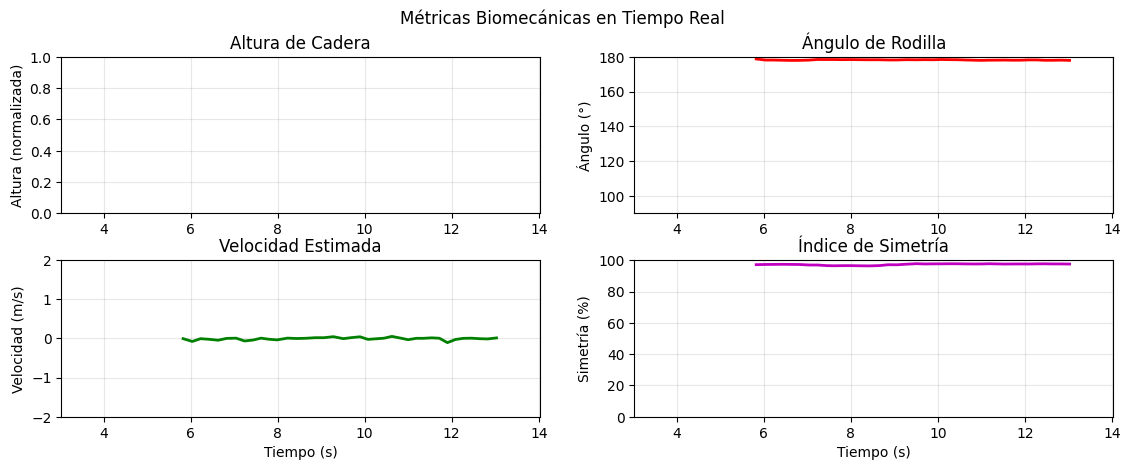

In [ ]:
"""
SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO
================================================================

Este sistema implementa una soluci√≥n h√≠brida inercial-visual para el an√°lisis 
t√©cnico y f√≠sico del salto largo en deportistas. Combina:

1. AN√ÅLISIS VISUAL: Utiliza MediaPipe para detectar 33 puntos clave del cuerpo humano
2. SIMULACI√ìN IMU: Simula 11 sensores inerciales distribuidos estrat√©gicamente
3. AN√ÅLISIS BIOMEC√ÅNICO: Calcula m√©tricas espec√≠ficas del salto largo en tiempo real
4. INTERFAZ GR√ÅFICA: Proporciona visualizaci√≥n y control del sistema

CARACTER√çSTICAS PRINCIPALES:
- An√°lisis en tiempo real de t√©cnica de salto
- C√°lculo de centro de masa corporal
- Medici√≥n de √°ngulos articulares cr√≠ticos
- Evaluaci√≥n de simetr√≠a bilateral
- Exportaci√≥n de datos para an√°lisis posterior

REQUISITOS T√âCNICOS:
- Python 3.8+
- OpenCV para captura de video
- MediaPipe para an√°lisis postural
- Tkinter para interfaz gr√°fica
- Matplotlib para gr√°ficos en tiempo real

Autor: Daniel Andres Ramirez Segura
Versi√≥n: 1.1
Fecha Creaci√≥n: 01 Agosto 2025
Actualizaci√≥n: 12 Agosto 2025
"""

# Importaci√≥n de librer√≠as necesarias para el procesamiento de video, datos y visualizaci√≥n.
# cv2: Librer√≠a OpenCV para captura y manipulaci√≥n de video desde la c√°mara.
import cv2
# np: NumPy para operaciones matem√°ticas y manejo de arrays num√©ricos, esencial para c√°lculos biomec√°nicos.
import numpy as np
# pd: Pandas para manejar datos en formato tabular, √∫til para exportar resultados a CSV.
import pandas as pd
# mp: MediaPipe, framework de Google para detecci√≥n de poses humanas en tiempo real.
import mediapipe as mp
# threading: Para ejecutar procesos en hilos paralelos, como la captura de video sin bloquear la interfaz gr√°fica.
import threading
# queue: Para manejar colas de datos entre hilos, aunque en este c√≥digo se usa deque para buffers.
import queue
# time: Para manejar tiempos, delays y timestamps en la captura de datos.
import time
# datetime: Para generar timestamps y nombres de archivos basados en fechas.
from datetime import datetime
# json: Para exportar metadatos en formato JSON.
import json
# math: Para funciones matem√°ticas b√°sicas, aunque aqu√≠ se usa m√°s NumPy.
import math
# deque: Estructura de cola doblemente terminada de collections, usada para buffers circulares de datos (eficiente en memoria).
from collections import deque
# logging: Para registrar eventos, errores y mensajes del sistema de manera estructurada.
import logging
# tk: Tkinter, librer√≠a est√°ndar de Python para crear interfaces gr√°ficas de usuario (GUI).
import tkinter as tk
# ttk, filedialog, messagebox: Componentes avanzados de Tkinter para widgets estilizados, di√°logos de archivos y mensajes.
from tkinter import ttk, filedialog, messagebox
# plt: Matplotlib para generar gr√°ficos y visualizaciones de datos en tiempo real.
import matplotlib.pyplot as plt
# FigureCanvasTkAgg: Backend para integrar gr√°ficos de Matplotlib en Tkinter.
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# FuncAnimation: Para animar gr√°ficos en tiempo real, aunque aqu√≠ se actualizan manualmente.
from matplotlib.animation import FuncAnimation
# os: Para operaciones del sistema operativo, como manejo de paths (aunque no se usa expl√≠citamente aqu√≠).
import os
# Image, ImageTk: De PIL (Pillow) para manejar y convertir im√°genes para mostrar en Tkinter.
from PIL import Image, ImageTk
# warnings: Para suprimir advertencias innecesarias durante la ejecuci√≥n.
import warnings
# Ignorar todas las advertencias para una ejecuci√≥n m√°s limpia (no recomendado en producci√≥n, pero √∫til para depuraci√≥n).
warnings.filterwarnings("ignore")

# Configuraci√≥n del sistema de logging para registrar eventos.
# Nivel INFO: Registra informaci√≥n general, errores y advertencias.
# Formato: Incluye timestamp, nivel y mensaje.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Obtener el logger principal para usar en todo el c√≥digo.
logger = logging.getLogger(__name__)

# A√ëADIR AL INICIO DEL ARCHIVO (despu√©s de los imports): Importa re para expresiones regulares usadas en validaciones.
import re
# Importa psutil para monitoreo de recursos del sistema (RAM, CPU).
import psutil  # pip install psutil
# Importa Path de pathlib para manejo de directorios y paths de archivos de manera portable.
from pathlib import Path


# =============================================================================
# CLASE PRINCIPAL: ADQUISICI√ìN DE DATOS VISUALES
# =============================================================================

class AdquisicionDataCamara:
    """
    CLASE PARA ADQUISICI√ìN Y PROCESAMIENTO DE DATOS VISUALES
    
    Esta clase es el n√∫cleo del an√°lisis visual del sistema. Se encarga de:
    - Capturar video desde la c√°mara del computador
    - Procesar cada frame con MediaPipe para detectar poses humanas
    - Calcular m√©tricas biomec√°nicas espec√≠ficas del salto largo
    - Almacenar datos en buffers circulares para an√°lisis en tiempo real
    
    FUNCIONAMIENTO:
    1. Inicializa la c√°mara con resoluci√≥n y FPS espec√≠ficos
    2. Cada frame capturado se procesa con MediaPipe
    3. Se extraen 33 puntos clave del cuerpo humano
    4. Se calculan m√©tricas biomec√°nicas derivadas
    5. Los datos se almacenan para an√°lisis posterior

    Jerarqu√≠a: Esta clase es independiente pero se integra con la interfaz gr√°fica (Interfaz_Biomecanica) 
    para control y visualizaci√≥n. Es el componente base para el an√°lisis visual, y se ejecuta en un hilo 
    separado para no bloquear la GUI. End-users: Entiendan que esta clase maneja la c√°mara y procesa 
    los frames en tiempo real; si hay problemas con la c√°mara, revisen aqu√≠.
    """

    # Constructor de la clase: Inicializa par√°metros y componentes.
    # camera_id: ID de la c√°mara (por defecto 0, la c√°mara principal).
    # fps: Frames por segundo deseados.
    # resolution: Resoluci√≥n del video (ancho, alto).
    def __init__(self, camera_id=0, fps=30, resolution=(1280, 720)):
        # Asigna el ID de la c√°mara.
        self.camera_id = camera_id
        # Asigna los FPS deseados.
        self.fps = fps
        # Asigna la resoluci√≥n deseada.
        self.resolution = resolution
        # Bandera para indicar si se est√° grabando.
        self.is_recording = False
        # Bandera para mostrar previsualizaci√≥n de video.
        self.show_preview = True
        # Objeto para escribir video (inicialmente None).
        self.video_writer = None
        # Nombre del archivo de video (inicialmente None).
        self.video_filename = None
        # Frame actual procesado.
        self.current_frame = None
        # Carga el m√≥dulo de pose de MediaPipe.
        self.mp_pose = mp.solutions.pose
        # Carga el m√≥dulo de dibujo de MediaPipe para visualizar landmarks.
        self.mp_drawing = mp.solutions.drawing_utils
        # Inicializa el modelo de detecci√≥n de pose con par√°metros espec√≠ficos:
        # - static_image_mode=False: Para video en tiempo real.
        # - model_complexity=2: Alta complejidad para precisi√≥n.
        # - enable_segmentation=False: No segmenta el fondo.
        # - min_detection_confidence=0.7: Confianza m√≠nima para detecci√≥n inicial.
        # - min_tracking_confidence=0.8: Confianza m√≠nima para seguimiento.
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=False,
            min_detection_confidence=0.7,
            min_tracking_confidence=0.8
        )
        # Buffer circular para datos visuales (m√°ximo 5000 muestras para optimizar memoria).
        self.visual_data_buffer = deque(maxlen=5000)  # Reducido para mejor rendimiento
        # Buffer circular para frames procesados (m√°ximo 30 para previsualizaci√≥n).
        self.frame_buffer = deque(maxlen=30)  # Reducido para optimizar memoria
        # Llama al m√©todo para inicializar la c√°mara.
        self.iniciar_camara()

    # M√©todo para inicializar la captura de video desde la c√°mara.
    def iniciar_camara(self):
        # Bloque try para manejar errores en la inicializaci√≥n.
        try:
            # Crea el objeto de captura de video con el ID especificado.
            self.cap = cv2.VideoCapture(self.camera_id)
            # Verifica si la c√°mara se abri√≥ correctamente.
            if not self.cap.isOpened():
                # Lanza excepci√≥n si no se puede abrir.
                raise Exception(f"No se puede abrir la c√°mara {self.camera_id}")
            # Configura el ancho del frame.
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.resolution[0])
            # Configura el alto del frame.
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.resolution[1])
            # Configura los FPS deseados.
            self.cap.set(cv2.CAP_PROP_FPS, self.fps)
            # Configura el buffer de la c√°mara a 1 para minimizar latencia.
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
            # Obtiene los FPS reales configurados.
            actual_fps = self.cap.get(cv2.CAP_PROP_FPS)
            # Obtiene el ancho real.
            actual_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            # Obtiene el alto real.
            actual_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            # Registra informaci√≥n sobre la configuraci√≥n real de la c√°mara.
            logger.info(f"C√°mara inicializada: {actual_width}x{actual_height} @ {actual_fps} FPS")
        # Maneja excepciones en la inicializaci√≥n.
        except Exception as e:
            # Registra el error.
            logger.error(f"Error inicializando c√°mara: {e}")
            # Relanza la excepci√≥n para manejo superior.
            raise

    # M√©todo para procesar un frame individual con MediaPipe.
    def procesar_frame_mediapipe(self, frame):
        # Bloque try para manejar errores en el procesamiento.
        try:
            # Copia el frame original para modificaciones.
            self.current_frame = frame.copy()
            # Si se est√° grabando video y el writer est√° abierto:
            if self.video_writer and self.video_writer.isOpened():
                # Convierte el frame a RGB (MediaPipe requiere RGB).
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Procesa el frame con el modelo de pose.
                results = self.pose.process(rgb_frame)
                # Si se detectan landmarks:
                if results.pose_landmarks:
                    # Dibuja los landmarks y conexiones en el frame para el video grabado.
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )
                # Escribe el frame procesado en el video.
                self.video_writer.write(self.current_frame)
            # Convierte el frame a RGB para procesamiento.
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Procesa el frame con MediaPipe para obtener landmarks.
            results = self.pose.process(rgb_frame)
            # Diccionario para almacenar datos de landmarks.
            landmarks_data = {}
            # Si se detectan landmarks:
            if results.pose_landmarks:
                # Obtiene la lista de landmarks.
                landmarks = results.pose_landmarks.landmark
                # Itera sobre los 33 landmarks est√°ndar de MediaPipe.
                for idx, landmark in enumerate(landmarks):
                    # Almacena coordenada X normalizada.
                    landmarks_data[f'landmark_{idx}_x'] = landmark.x
                    # Almacena coordenada Y normalizada.
                    landmarks_data[f'landmark_{idx}_y'] = landmark.y
                    # Almacena coordenada Z relativa.
                    landmarks_data[f'landmark_{idx}_z'] = landmark.z
                    # Almacena visibilidad (confianza) del landmark.
                    landmarks_data[f'landmark_{idx}_visibility'] = landmark.visibility
                # Calcula m√©tricas biomec√°nicas a partir de los landmarks.
                bio_metrics = self.calcular_metricas_biomecanicas(landmarks)
                # Actualiza el diccionario con las m√©tricas biomec√°nicas.
                landmarks_data.update(bio_metrics)
                # Calcula m√©tricas de calidad de la detecci√≥n.
                quality_metrics = self.calcular_metricas_de_calidad(landmarks)
                # Actualiza el diccionario con m√©tricas de calidad.
                landmarks_data.update(quality_metrics)
                # Si se debe mostrar previsualizaci√≥n:
                if self.show_preview:
                    # Dibuja landmarks en el frame actual para visualizaci√≥n.
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )

                        # Dibuja el centro de masa si est√° calculado
                    if 'center_of_mass_x' in bio_metrics and 'center_of_mass_y' in bio_metrics:
                        self.dibujar_centro_de_masa(self.current_frame, bio_metrics['center_of_mass_x'], bio_metrics['center_of_mass_y'])                
                    # Agrega el frame procesado al buffer.
                    self.frame_buffer.append(self.current_frame.copy())
            # Si no se detectan landmarks, usa valores vac√≠os.
            else:
                landmarks_data = self._get_empty_landmarks()
            # Retorna los datos procesados.
            return landmarks_data
        # Maneja excepciones en el procesamiento.
        except Exception as e:
            # Registra el error.
            logger.error(f"Error procesando frame: {e}")
            # Retorna datos vac√≠os en caso de error.
            return self._get_empty_landmarks()

    # M√©todo privado para obtener un diccionario de landmarks vac√≠o con NaN.
    def _get_empty_landmarks(self):
        # Inicializa diccionario vac√≠o.
        landmarks_data = {}
        # Para cada uno de los 33 landmarks:
        for idx in range(33):
            # Asigna NaN a coordenadas X, Y, Z.
            landmarks_data[f'landmark_{idx}_x'] = np.nan
            landmarks_data[f'landmark_{idx}_y'] = np.nan
            landmarks_data[f'landmark_{idx}_z'] = np.nan
            # Asigna 0 a visibilidad.
            landmarks_data[f'landmark_{idx}_visibility'] = 0.0
        # Agrega m√©tricas biomec√°nicas vac√≠as con NaN o 0.
        landmarks_data.update({
            'detection_confidence': 0.0,
            'detection_completeness': 0.0,
            'valid_landmarks': 0,
            'center_of_mass_x': np.nan,
            'center_of_mass_y': np.nan,
            'knee_angle_right': np.nan,
            'knee_angle_left': np.nan,
            'trunk_angle': np.nan,
            'hip_height': np.nan,
            'symmetry_index': 0.0,
            'velocity_x_estimated': 0.0
        })
        # Retorna el diccionario vac√≠o.
        return landmarks_data

    # M√©todo para calcular m√©tricas biomec√°nicas espec√≠ficas del salto largo.
    def calcular_metricas_biomecanicas(self, landmarks):
        # Diccionario para m√©tricas.
        metrics = {}
        # Bloque try para manejar errores en c√°lculos.
        try:
            # Calcula centro de masa (COM) en X e Y.
            com_x, com_y = self.calcular_centro_de_masa(landmarks)
            # Almacena COM X.
            metrics['center_of_mass_x'] = com_x
            # Almacena COM Y.
            metrics['center_of_mass_y'] = com_y
            # Calcula √°ngulo de rodilla derecha usando landmarks 24,26,28 (cadera, rodilla, tobillo).
            knee_angle_r = self.calcular_angulo_articular(landmarks[24], landmarks[26], landmarks[28])
            # Almacena √°ngulo rodilla derecha.
            metrics['knee_angle_right'] = knee_angle_r
            # Calcula √°ngulo de rodilla izquierda usando landmarks 23,25,27.
            knee_angle_l = self.calcular_angulo_articular(landmarks[23], landmarks[25], landmarks[27])
            # Almacena √°ngulo rodilla izquierda.
            metrics['knee_angle_left'] = knee_angle_l
            # Calcula √°ngulo del tronco.
            trunk_angle = self.calcular_angulo_tronco(landmarks)
            # Almacena √°ngulo tronco.
            metrics['trunk_angle'] = trunk_angle
            # Calcula altura de cadera como promedio invertido de Y de caderas (normalizado).
            hip_height = (landmarks[23].y + landmarks[24].y) / 2
            # Almacena altura de cadera (1 - y para que m√°s alto sea mayor valor).
            metrics['hip_height'] = 1.0 - hip_height
            # Calcula √≠ndice de simetr√≠a bilateral.
            symmetry_index = self.calcular_simetria_bilateral(landmarks)
            # Almacena simetr√≠a.
            metrics['symmetry_index'] = symmetry_index
            # Si hay datos previos en el buffer:
            if len(self.visual_data_buffer) > 0:
                # Obtiene COM X previo.
                prev_com_x = self.visual_data_buffer[-1].get('center_of_mass_x', com_x)
                # Calcula delta de tiempo basado en FPS.
                time_delta = 1.0 / self.fps
                # Estima velocidad en X como cambio en COM / delta tiempo.
                velocity_x = (com_x - prev_com_x) / time_delta if time_delta > 0 else 0
                # Almacena velocidad estimada.
                metrics['velocity_x_estimated'] = velocity_x
            # Si no hay datos previos, velocidad 0.
            else:
                metrics['velocity_x_estimated'] = 0.0
        # Maneja excepciones en c√°lculos.
        except Exception as e:
            # Registra advertencia.
            logger.warning(f"Error calculando m√©tricas biomec√°nicas: {e}")
        # Retorna las m√©tricas.
        return metrics

    def dibujar_centro_de_masa(self, frame, com_x, com_y):
            # Convierte coordenadas normalizadas a p√≠xeles
            height, width = frame.shape[:2]
            com_x_px = int(com_x * width)
            com_y_px = int(com_y * height)
            # Dibuja punto en el centro de masa
            cv2.circle(frame, (com_x_px, com_y_px), 5, (0, 0, 255), -1)  # Punto rojo
            # A√±ade etiqueta
            cv2.putText(frame, "centro de masa", (com_x_px + 10, com_y_px - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # M√©todo para calcular el centro de masa aproximado usando pesos segmentales.
    def calcular_centro_de_masa(self, landmarks):
        # Diccionario de pesos relativos de segmentos corporales (aproximados para modelo biomec√°nico).
        segment_weights = {
            'head': 0.08, 'trunk': 0.50, 'arms': 0.10, 'thighs': 0.20, 'shanks': 0.12
        }
        # Calcula posici√≥n media de cabeza (landmark 0).
        head_x, head_y = landmarks[0].x, landmarks[0].y
        # Calcula posici√≥n media de tronco (promedio de hombros y caderas: 11,12,23,24).
        trunk_x = (landmarks[11].x + landmarks[12].x + landmarks[23].x + landmarks[24].x) / 4
        trunk_y = (landmarks[11].y + landmarks[12].y + landmarks[23].y + landmarks[24].y) / 4
        # Calcula posici√≥n media de brazos (promedio de codos y mu√±ecas: 13,14,15,16).
        arms_x = (landmarks[13].x + landmarks[14].x + landmarks[15].x + landmarks[16].x) / 4
        arms_y = (landmarks[13].y + landmarks[14].y + landmarks[15].y + landmarks[16].y) / 4
        # Calcula posici√≥n media de muslos (promedio de rodillas: 25,26).
        thighs_x = (landmarks[25].x + landmarks[26].x) / 2
        thighs_y = (landmarks[25].y + landmarks[26].y) / 2
        # Calcula posici√≥n media de piernas inferiores (promedio de tobillos: 27,28).
        shanks_x = (landmarks[27].x + landmarks[28].x) / 2
        shanks_y = (landmarks[27].y + landmarks[28].y) / 2
        # Calcula COM ponderado en X sumando peso * posici√≥n.
        com_x = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_x, trunk_x, arms_x, thighs_x, shanks_x]))
        # Calcula COM ponderado en Y de manera similar.
        com_y = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_y, trunk_y, arms_y, thighs_y, shanks_y]))
        # Retorna COM X e Y.
        return com_x, com_y

    # M√©todo para calcular √°ngulo entre tres puntos (usando ley del coseno).
    def calcular_angulo_articular(self, point1, point2, point3):
        # Bloque try para manejar errores.
        try:
            # Convierte puntos a arrays NumPy para vectores.
            a = np.array([point1.x, point1.y])
            b = np.array([point2.x, point2.y])
            c = np.array([point3.x, point3.y])
            # Vector BA.
            ba = a - b
            # Vector BC.
            bc = c - b
            # Calcula coseno del √°ngulo usando producto punto.
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            # Limita el coseno entre -1 y 1 para evitar errores num√©ricos.
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            # Calcula √°ngulo en radianes.
            angle = np.arccos(cosine_angle)
            # Convierte a grados y retorna.
            return np.degrees(angle)
        # En caso de error (ej. divisi√≥n por cero), retorna NaN.
        except:
            return np.nan

    # M√©todo para calcular √°ngulo del tronco respecto a la vertical.
    def calcular_angulo_tronco(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Posici√≥n media de hombros (11,12).
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            # Posici√≥n media de caderas (23,24).
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2
            # Vector del tronco (de hombros a caderas).
            trunk_vector = np.array([hip_mid_x - shoulder_mid_x, hip_mid_y - shoulder_mid_y])
            # Vector vertical de referencia.
            vertical_vector = np.array([0, 1])
            # Calcula coseno del √°ngulo entre tronco y vertical.
            cosine_angle = np.dot(trunk_vector, vertical_vector) / (
                np.linalg.norm(trunk_vector) * np.linalg.norm(vertical_vector)
            )
            # Limita coseno.
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            # Calcula √°ngulo en radianes.
            angle = np.arccos(cosine_angle)
            # Convierte a grados y retorna.
            return np.degrees(angle)
        # En caso de error, retorna NaN.
        except:
            return np.nan

    # M√©todo para calcular simetr√≠a bilateral basada en posiciones de rodillas y tobillos.
    def calcular_simetria_bilateral(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Posici√≥n Y de rodilla izquierda (25).
            left_knee_y = landmarks[25].y
            # Posici√≥n Y de rodilla derecha (26).
            right_knee_y = landmarks[26].y
            # Posici√≥n Y de tobillo izquierdo (27).
            left_ankle_y = landmarks[27].y
            # Posici√≥n Y de tobillo derecho (28).
            right_ankle_y = landmarks[28].y
            # Diferencia absoluta en rodillas.
            knee_diff = abs(left_knee_y - right_knee_y)
            # Diferencia absoluta en tobillos.
            ankle_diff = abs(left_ankle_y - right_ankle_y)
            # Calcula simetr√≠a como 100 * (1 - promedio de diferencias).
            symmetry = 100 * (1 - (knee_diff + ankle_diff) / 2)
            # Retorna m√°ximo entre 0 y simetr√≠a (para evitar negativos).
            return max(0, symmetry)
        # En caso de error, retorna 0.
        except:
            return 0.0

    # M√©todo para calcular m√©tricas de calidad de la detecci√≥n.
    def calcular_metricas_de_calidad(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Landmarks clave para salto largo (hombros, caderas, rodillas, tobillos).
            key_landmarks = [11, 12, 13, 14, 23, 24, 25, 26, 27, 28]
            # Lista de visibilidades de landmarks clave.
            confidences = [landmarks[i].visibility for i in key_landmarks]
            # Confianza promedio.
            avg_confidence = np.mean(confidences)
            # Conteo de landmarks v√°lidos (visibilidad > 0.5).
            valid_landmarks = sum(1 for conf in confidences if conf > 0.5)
            # Completitud como proporci√≥n de v√°lidos.
            completeness = valid_landmarks / len(key_landmarks)
            # Retorna diccionario con m√©tricas.
            return {
                'detection_confidence': avg_confidence,
                'detection_completeness': completeness,
                'valid_landmarks': valid_landmarks
            }
        # En caso de error, retorna valores cero.
        except:
            return {
                'detection_confidence': 0.0,
                'detection_completeness': 0.0,
                'valid_landmarks': 0
            }

    # M√©todo principal para capturar datos visuales en un bucle mientras se graba.
    def capturar_datos_visuales(self):
        # Contador de frames.
        frame_count = 0
        # Timestamp de inicio.
        start_time = time.time()
        # Bucle mientras se est√© grabando.
        while self.is_recording:
            # Lee un frame de la c√°mara.
            ret, frame = self.cap.read()
            # Si se ley√≥ correctamente:
            if ret:
                # Obtiene timestamp actual.
                timestamp = time.time()
                # Procesa el frame con MediaPipe.
                landmarks_data = self.procesar_frame_mediapipe(frame)
                # Crea diccionario de muestra visual con timestamp y datos.
                visual_sample = {
                    'timestamp': timestamp,
                    'frame_number': frame_count,
                    'elapsed_time': timestamp - start_time,
                    **landmarks_data
                }
                # Agrega la muestra al buffer.
                self.visual_data_buffer.append(visual_sample)
                # Incrementa contador de frames.
                frame_count += 1
                # Calcula tiempo esperado para el pr√≥ximo frame (para mantener FPS).
                expected_time = start_time + (frame_count / self.fps)
                # Tiempo actual.
                current_time = time.time()
                # Tiempo de sleep para sincronizar.
                sleep_time = expected_time - current_time
                # Si positivo, duerme.
                if sleep_time > 0:
                    time.sleep(sleep_time)
            # Si no se ley√≥ frame, advierte y duerme brevemente.
            else:
                logger.warning("No se pudo capturar frame de la c√°mara")
                time.sleep(0.1)

    # M√©todo para obtener el √∫ltimo frame del buffer.
    def obtener_ultimo_frame(self):
        # Si hay frames, retorna el √∫ltimo.
        if self.frame_buffer:
            return self.frame_buffer[-1]
        # Sino, None.
        return None

    # M√©todo para comenzar la grabaci√≥n en un hilo separado.
    def comenzar_grabacion(self):
        # Activa bandera de grabaci√≥n.
        self.is_recording = True
        # Crea hilo para captura visual (daemon para que termine con el programa).
        self.hilo_visual = threading.Thread(target=self.capturar_datos_visuales, daemon=True)
        # Inicia el hilo.
        self.hilo_visual.start()
        # Registra inicio.
        logger.info("Grabaci√≥n visual iniciada")

    # M√©todo para detener la grabaci√≥n.
    def detener_grabacion(self):
        # Desactiva bandera.
        self.is_recording = False
        # Si existe el hilo, espera a que termine (timeout 2s).
        if hasattr(self, 'hilo_visual'):
            self.hilo_visual.join(timeout=2)
        # Si existe writer de video, lo libera.
        if self.video_writer:
            self.video_writer.release()
            self.video_writer = None
            # Registra guardado de video.
            logger.info(f"Video guardado: {self.video_filename}")
        # Registra detenci√≥n.
        logger.info("Grabaci√≥n visual detenida")

    # M√©todo para obtener todos los datos visuales del buffer como lista.
    def obtener_datos_visuales(self):
        return list(self.visual_data_buffer)

    # M√©todo para obtener el frame actual.
    def obtener_frame_actual(self):
        return self.current_frame

    # M√©todo para iniciar grabaci√≥n de video a archivo.
    def iniciar_grabacion_video(self, filename=None):
        # Si no se da nombre, genera uno con timestamp.
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"salto_largo_{timestamp}.mp4"
        # Asigna nombre de archivo.
        self.video_filename = filename
        # Codec para MP4.
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        # Crea writer de video con codec, FPS y resoluci√≥n.
        self.video_writer = cv2.VideoWriter(
            filename,
            fourcc,
            self.fps,
            self.resolution
        )
        # Si no se abre, registra error y retorna False.
        if not self.video_writer.isOpened():
            logger.error(f"No se pudo crear el archivo de video: {filename}")
            self.video_writer = None
            return False
        # Registra inicio de grabaci√≥n video.
        logger.info(f"Grabaci√≥n de video iniciada: {filename}")
        return True

    # Destructor: Libera recursos al destruir la instancia.
    def __del__(self):
        # Libera writer si existe.
        if hasattr(self, 'video_writer') and self.video_writer:
            self.video_writer.release()
        # Libera captura de c√°mara si existe.
        if hasattr(self, 'cap'):
            self.cap.release()

# =============================================================================
# CLASE 2: SIMULACI√ìN DE SENSORES IMU
# =============================================================================
class Simulador_IMU:
    """
    SIMULADOR DE SENSORES INERCIALES (IMU) PARA DESARROLLO
    
    Esta clase simula el comportamiento de 11 sensores ICM-20948 distribuidos
    estrat√©gicamente en el cuerpo del atleta. La simulaci√≥n se basa en:
    
    FUNCIONAMIENTO:
    1. Recibe datos del an√°lisis visual (poses, movimientos)
    2. Simula se√±ales de aceler√≥metro, giroscopio y magnet√≥metro
    3. A√±ade ruido realista seg√∫n la ubicaci√≥n del sensor
    4. Genera datos a alta frecuencia (1000 Hz) vs video (30 Hz)
    
    PROP√ìSITO:
    - Permitir desarrollo sin hardware real
    - Generar datos sint√©ticos para entrenamiento de modelos
    - Validar algoritmos de fusi√≥n sensorial
    - Demostrar capacidades del sistema completo
    
    UBICACI√ìN DE LOS 11 SENSORES SIMULADOS:
    0: Cabeza - movimiento suave, poca aceleraci√≥n
    1-2: Brazos - movimiento moderado durante t√©cnica de vuelo
    3-4: Antebrazos - movimiento m√°s din√°mico
    5: Pecho - representa tronco, movimiento central
    6: Lumbar - centro de masa, se√±al cr√≠tica
    7-8: Muslos - alta aceleraci√≥n durante despegue
    9-10: Tobillos - m√°xima aceleraci√≥n durante contacto con suelo
    """
    
    # Constructor de la clase: Inicializa par√°metros y componentes.
    # num_sensors: N√∫mero de sensores a simular (11 por defecto).
    # sample_rate: Frecuencia de muestreo en Hz (1000 Hz por defecto).
    def __init__(self, num_sensors=11, sample_rate=1000):
        """
        INICIALIZACI√ìN DEL SIMULADOR IMU
        
        Par√°metros:
        - num_sensors: N√∫mero de sensores a simular (11 por defecto)
        - sample_rate: Frecuencia de muestreo en Hz (1000 Hz = 1 muestra/ms)
        """
        # Asigna n√∫mero de sensores.
        self.num_sensors = num_sensors
        # Asigna frecuencia de muestreo.
        self.sample_rate = sample_rate
        # Flag de control de grabaci√≥n (inicialmente False).
        self.is_recording = False  # Flag de control de grabaci√≥n
        
        # Buffer circular para almacenar datos IMU simulados (capacidad para ~50 segundos a 1000 Hz).
        self.imu_data_buffer = deque(maxlen=50000)
        
        # =============================================================
        # CONFIGURACI√ìN ESPEC√çFICA POR SENSOR
        # =============================================================
        # Cada sensor tiene caracter√≠sticas espec√≠ficas seg√∫n su ubicaci√≥n:
        # - location: Ubicaci√≥n anat√≥mica del sensor
        # - noise_level: Nivel de ruido base (menor = m√°s preciso)
        
        self.sensor_config = {
            0: {'location': 'cabeza', 'noise_level': 0.1},        # Movimiento suave
            1: {'location': 'brazo_izq', 'noise_level': 0.3},     # Movimiento moderado
            2: {'location': 'brazo_der', 'noise_level': 0.3},     # Movimiento moderado
            3: {'location': 'antebrazo_izq', 'noise_level': 0.4}, # M√°s din√°mico
            4: {'location': 'antebrazo_der', 'noise_level': 0.4}, # M√°s din√°mico
            5: {'location': 'pecho', 'noise_level': 0.2},         # Centro del tronco
            6: {'location': 'lumbar', 'noise_level': 0.5},        # Centro de masa
            7: {'location': 'muslo_izq', 'noise_level': 0.6},     # Alta aceleraci√≥n
            8: {'location': 'muslo_der', 'noise_level': 0.6},     # Alta aceleraci√≥n
            9: {'location': 'tobillo_izq', 'noise_level': 0.8},   # M√°xima aceleraci√≥n
            10: {'location': 'tobillo_der', 'noise_level': 0.8}   # M√°xima aceleraci√≥n
        }
        
        # Variables de estado para la simulaci√≥n
        self.last_visual_data = None  # √öltimos datos visuales recibidos
        self.simulation_time = 0      # Tiempo interno de simulaci√≥n
    
    # M√©todo para actualizar el estado de simulaci√≥n con datos visuales nuevos.
    def actualizacion_datos_visuales(self, visual_data):
        """
        ACTUALIZACI√ìN DEL ESTADO DE SIMULACI√ìN
        
        Esta funci√≥n recibe los datos m√°s recientes del an√°lisis visual
        y actualiza el estado interno del simulador para generar
        se√±ales IMU coherentes con el movimiento observado.
        """
        # Asigna los datos visuales recibidos al estado interno.
        self.last_visual_data = visual_data
    
    # M√©todo para simular datos IMU basados en una muestra visual.
    def simular_imu_pose(self, visual_sample):
        """
        SIMULACI√ìN DE DATOS IMU BASADA EN POSE VISUAL
        
        Esta es la funci√≥n central de la simulaci√≥n. Toma una muestra
        del an√°lisis visual y genera m√∫ltiples muestras IMU correspondientes.
        
        PROCESO:
        1. Extrae m√©tricas de movimiento del an√°lisis visual
        2. Calcula cu√°ntas muestras IMU generar por frame de video
        3. Para cada sensor, simula se√±ales realistas
        4. A√±ade ruido apropiado seg√∫n la ubicaci√≥n
        
        La relaci√≥n t√≠pica es ~33 muestras IMU por frame de video
        (1000 Hz IMU / 30 Hz video = 33.3)
        """
        # Si no hay muestra visual, retorna lista vac√≠a.
        if not visual_sample:
            return []
        
        # Lista para muestras simuladas.
        simulated_samples = []
        # Timestamp base de la muestra visual.
        base_timestamp = visual_sample.get('timestamp', time.time())
        
        # =============================================================
        # C√ÅLCULO DE MUESTRAS POR FRAME
        # =============================================================
        # Generar m√∫ltiples muestras IMU por cada frame de video
        # para simular la mayor frecuencia de los sensores inerciales
        samples_per_frame = max(1, int(self.sample_rate / 30))  # Asumiendo 30 FPS
        
        # Generar muestras con timestamps incrementales
        for i in range(samples_per_frame):
            # Offset de timestamp para cada muestra.
            timestamp_offset = i * (1.0 / self.sample_rate)
            
            # Generar datos para cada uno de los 11 sensores
            for sensor_id, config in self.sensor_config.items():
                # Genera datos para el sensor espec√≠fico.
                imu_sample = self.generar_datos_sensor(
                    sensor_id, 
                    config, 
                    visual_sample, 
                    base_timestamp + timestamp_offset
                )
                # Agrega la muestra a la lista.
                simulated_samples.append(imu_sample)
        
        # Retorna las muestras simuladas.
        return simulated_samples
    
    # M√©todo para generar datos de un sensor espec√≠fico.
    def generar_datos_sensor(self, sensor_id, config, visual_sample, timestamp):
        """
        GENERACI√ìN DE DATOS PARA UN SENSOR ESPEC√çFICO
        
        Esta funci√≥n simula las se√±ales de un sensor ICM-20948 real:
        
        SE√ëALES SIMULADAS:
        1. ACELER√ìMETRO (3 ejes): Mide aceleraci√≥n lineal en g's
           - accel_x: Aceleraci√≥n horizontal (direcci√≥n de carrera)
           - accel_y: Aceleraci√≥n vertical (gravedad + salto)
           - accel_z: Aceleraci√≥n lateral (estabilidad)
        
        2. GIROSCOPIO (3 ejes): Mide velocidad angular en ¬∞/s
           - gyro_x, gyro_y, gyro_z: Rotaciones alrededor de cada eje
        
        3. MAGNET√ìMETRO (3 ejes): Mide campo magn√©tico en ŒºT
           - mag_x, mag_y, mag_z: Campo magn√©tico terrestre + ruido
        
        La simulaci√≥n se basa en:
        - Ubicaci√≥n del sensor en el cuerpo
        - M√©tricas de movimiento del an√°lisis visual
        - Modelos f√≠sicos de movimiento humano
        - Ruido realista seg√∫n la ubicaci√≥n
        """
        # Obtiene ubicaci√≥n del sensor.
        location = config['location']
        # Obtiene nivel de ruido.
        noise_level = config['noise_level']
        
        # =============================================================
        # EXTRACCI√ìN DE M√âTRICAS DE MOVIMIENTO
        # =============================================================
        # Velocidad horizontal estimada.
        velocity_x = visual_sample.get('velocity_x_estimated', 0.0)  # Velocidad horizontal
        # Altura de cadera.
        hip_height = visual_sample.get('hip_height', 0.5)            # Altura de caderas
        # √Ångulo de rodilla derecha.
        knee_angle_r = visual_sample.get('knee_angle_right', 180.0)  # √Ångulo de rodilla
        # √Ångulo del tronco.
        trunk_angle = visual_sample.get('trunk_angle', 90.0)         # √Ångulo del tronco
        
        # =============================================================
        # SIMULACI√ìN DE ACELER√ìMETRO POR UBICACI√ìN
        # =============================================================
        
        # Si es tobillo:
        if 'tobillo' in location:
            # TOBILLOS: Mayor aceleraci√≥n durante contacto con suelo
            # Durante el salto, los tobillos experimentan fuerzas de hasta 8-10g
            base_accel_y = -9.81 + (20 * (1 - hip_height))  # M√°s fuerza cuando est√° m√°s bajo
            base_accel_x = velocity_x * 10                   # Proporcional a velocidad
            base_accel_z = np.sin(np.radians(knee_angle_r)) * 5  # Relacionado con flexi√≥n
            
        # Si es muslo:
        elif 'muslo' in location:
            # MUSLOS: Aceleraci√≥n relacionada con √°ngulo de rodilla
            # Los muslos son cr√≠ticos durante la fase de despegue
            base_accel_y = -9.81 + np.cos(np.radians(knee_angle_r)) * 10
            base_accel_x = velocity_x * 8
            base_accel_z = np.sin(np.radians(trunk_angle)) * 3
            
        # Si es lumbar:
        elif 'lumbar' in location:
            # LUMBAR: Centro de masa, movimiento m√°s suave
            # Representa el centro de masa corporal total
            base_accel_y = -9.81 + (hip_height - 0.5) * 15
            base_accel_x = velocity_x * 5
            base_accel_z = 0  # Movimiento lateral m√≠nimo
            
        # Otros sensores:
        else:
            # OTROS SENSORES: Movimiento moderado (cabeza, brazos)
            base_accel_y = -9.81 + np.random.normal(0, 2)
            base_accel_x = velocity_x * 3
            base_accel_z = np.random.normal(0, 1)
        
        # =============================================================
        # ADICI√ìN DE RUIDO REALISTA
        # =============================================================
        # Los sensores reales tienen ruido caracter√≠stico
        noise_x = np.random.normal(0, noise_level)
        noise_y = np.random.normal(0, noise_level)
        noise_z = np.random.normal(0, noise_level)
        
        # =============================================================
        # SIMULACI√ìN DE GIROSCOPIO
        # =============================================================
        # Velocidades angulares con ruido proporcional
        gyro_noise = noise_level * 10  # Giroscopio t√≠picamente m√°s ruidoso
        base_gyro_x = np.random.normal(0, gyro_noise)
        base_gyro_y = np.random.normal(0, gyro_noise)
        base_gyro_z = np.random.normal(0, gyro_noise)
        
        # =============================================================
        # SIMULACI√ìN DE MAGNET√ìMETRO
        # =============================================================
        # Campo magn√©tico terrestre + perturbaciones
        mag_noise = noise_level * 5
        base_mag_x = 20 + np.random.normal(0, mag_noise)   # Componente Norte
        base_mag_y = 40 + np.random.normal(0, mag_noise)   # Componente Este
        base_mag_z = -30 + np.random.normal(0, mag_noise)  # Componente vertical
        
        # =============================================================
        # MUESTRA COMPLETA DEL SENSOR
        # =============================================================
        # Retorna diccionario con todos los datos simulados.
        return {
            'timestamp': timestamp,
            'sensor_id': sensor_id,
            'location': location,
            # Aceler√≥metro (m/s¬≤)
            'accel_x': base_accel_x + noise_x,
            'accel_y': base_accel_y + noise_y,
            'accel_z': base_accel_z + noise_z,
            # Giroscopio (¬∞/s)
            'gyro_x': base_gyro_x,
            'gyro_y': base_gyro_y,
            'gyro_z': base_gyro_z,
            # Magnet√≥metro (ŒºT)
            'mag_x': base_mag_x,
            'mag_y': base_mag_y,
            'mag_z': base_mag_z,
            'system_timestamp': timestamp
        }
    
    # M√©todo para simular datos IMU en un hilo.
    def simular_datos_imu(self, camera_system):
        """
        HILO PRINCIPAL DE SIMULACI√ìN IMU
        
        Esta funci√≥n se ejecuta en un hilo separado y:
        1. Obtiene datos visuales m√°s recientes
        2. Simula se√±ales IMU correspondientes
        3. Almacena datos en buffer circular
        4. Mantiene frecuencia de 1000 Hz
        
        La simulaci√≥n es s√≠ncrona con el an√°lisis visual
        """
        # Bucle mientras se grabe.
        while self.is_recording:
            # Obtener √∫ltimos datos del sistema de c√°mara
            visual_data = camera_system.obtener_datos_visuales()
            
            # Si hay datos visuales:
            if visual_data:
                # Tomar la muestra m√°s reciente
                latest_sample = visual_data[-1]
                
                # Simular datos IMU correspondientes
                simulated_samples = self.simular_imu_pose(latest_sample)
                
                # Almacenar todas las muestras generadas
                for sample in simulated_samples:
                    self.imu_data_buffer.append(sample)
            
            # Control de frecuencia de simulaci√≥n (duerme 1/sample_rate segundos).
            time.sleep(1.0 / self.sample_rate)
    
    # M√©todo para comenzar la grabaci√≥n de simulaci√≥n IMU.
    def comenzar_grabacion(self, camera_system):
        """Inicia la simulaci√≥n IMU en hilo separado"""
        # Activa flag de grabaci√≥n.
        self.is_recording = True
        # Asigna referencia al sistema de c√°mara.
        self.camera_system = camera_system
        # Crea hilo para simulaci√≥n (daemon=True).
        self.imu_thread = threading.Thread(target=self.simular_datos_imu, args=(camera_system,), daemon=True)
        # Inicia el hilo.
        self.imu_thread.start()
        # Registra inicio.
        logger.info("Simulaci√≥n IMU iniciada")
    
    # M√©todo para detener la grabaci√≥n de simulaci√≥n IMU.
    def detener_grabacion(self):
        """Detiene la simulaci√≥n IMU"""
        # Desactiva flag.
        self.is_recording = False
        # Si existe hilo, espera a que termine (timeout 2s).
        if hasattr(self, 'imu_thread'):
            self.imu_thread.join(timeout=2)
        # Registra detenci√≥n.
        logger.info("Simulaci√≥n IMU detenida")
    
    # M√©todo para obtener todos los datos IMU simulados como lista.
    def obtener_datos_imu(self):
        """Retorna todos los datos IMU simulados"""
        return list(self.imu_data_buffer)

    # M√©todo para validar coherencia entre sensores IMU.
    def validar_coherencia_imu(self):
        """
        VALIDACI√ìN DE COHERENCIA ENTRE SENSORES IMU
        Verifica que los sensores simulados sean consistentes entre s√≠
        """
        # Si menos de 10 muestras, retorna scores cero.
        if len(self.imu_data_buffer) < 10:
            return {'imu_coherencia': 0, 'acceleration_validity': 0}

        # Toma las √∫ltimas 50 muestras.
        recent_samples = list(self.imu_data_buffer)[-50:]  # √öltimas 50 muestras

        # Bloque try para c√°lculos.
        try:
            # Agrupar por timestamp (redondeado a 3 decimales).
            by_timestamp = {}
            for sample in recent_samples:
                ts = round(sample['timestamp'], 3)  # Redondear para agrupar
                if ts not in by_timestamp:
                    by_timestamp[ts] = []
                by_timestamp[ts].append(sample)

            # Validar coherencia bilateral
            coherence_scores = []
            acceleration_violations = 0
            total_samples = 0

            # L√≠mites de aceleraci√≥n por ubicaci√≥n
            accel_limits = {
                'tobillo': 25.0,  # g's
                'muslo': 20.0,
                'lumbar': 10.0,
                'brazo': 8.0,
                'cabeza': 5.0
            }

            # Para cada grupo de timestamp:
            for timestamp, sensors in by_timestamp.items():
                # Si al menos 2 sensores:
                if len(sensors) >= 2:
                    # Listas para aceleraciones izquierda y derecha.
                    left_accels = []
                    right_accels = []

                    # Para cada sensor en el grupo:
                    for sensor in sensors:
                        # Magnitud de aceleraci√≥n.
                        accel_mag = np.sqrt(sensor['accel_x']**2 + sensor['accel_y']**2 + sensor['accel_z']**2)

                        # Validar l√≠mites de aceleraci√≥n
                        limit = 15.0  # Por defecto
                        for loc, lim in accel_limits.items():
                            if loc in sensor['location']:
                                limit = lim
                                break
                            
                        # Si excede l√≠mite, incrementa violaciones.
                        if accel_mag > limit:
                            acceleration_violations += 1
                        # Incrementa total de muestras.
                        total_samples += 1

                        # Agrupar por lado
                        if 'izq' in sensor['location']:
                            left_accels.append(accel_mag)
                        elif 'der' in sensor['location']:
                            right_accels.append(accel_mag)

                    # Calcular simetr√≠a bilateral
                    if left_accels and right_accels:
                        # Promedio izquierda.
                        left_avg = np.mean(left_accels)
                        # Promedio derecha.
                        right_avg = np.mean(right_accels)
                        # Si m√°ximo > 0:
                        if max(left_avg, right_avg) > 0:
                            # Simetr√≠a como 1 - diferencia relativa.
                            symmetry = 1.0 - abs(left_avg - right_avg) / max(left_avg, right_avg)
                            # Agrega score (m√≠nimo 0).
                            coherence_scores.append(max(0, symmetry))

            # Calcular m√©tricas finales
            # Coherencia promedio.
            imu_coherence = np.mean(coherence_scores) if coherence_scores else 0
            # Validez de aceleraci√≥n como 1 - proporci√≥n de violaciones.
            acceleration_validity = 1.0 - (acceleration_violations / max(total_samples, 1))

            # Retorna diccionario con m√©tricas.
            return {
                'imu_coherence': imu_coherence,
                'acceleration_validity': acceleration_validity,
                'bilateral_samples': len(coherence_scores)
            }

        # Maneja excepciones.
        except Exception as e:
            # Registra advertencia.
            logger.warning(f"Error validando coherencia IMU: {e}")
            # Retorna scores cero.
            return {'imu_coherence': 0, 'acceleration_validity': 0}

# =============================================================================
# CLASE 3: INTERFAZ BIOMEC√ÅNICA
# =============================================================================

class Interfaz_Biomecanica:
    """
    CLASE PARA LA INTERFAZ GR√ÅFICA DE USUARIO (GUI)
    
    Esta clase maneja la interfaz gr√°fica con Tkinter, integrando el control de la c√°mara,
    visualizaci√≥n en tiempo real, gr√°ficos y exportaci√≥n de datos. Es el componente principal
    que el usuario final interact√∫a.

    FUNCIONAMIENTO:
    1. Crea ventana principal y widgets de control.
    2. Integra con AdquisicionDataCamara para captura visual.
    3. Muestra m√©tricas y gr√°ficos en tiempo real.
    4. Maneja exportaci√≥n de datos a CSV y JSON.
    
    Jerarqu√≠a: Esta clase es de alto nivel, depende de AdquisicionDataCamara para datos visuales
    y Simulador_IMU para simulaci√≥n inercial. End-users: 
    Esta es la parte que ven y usan; los botones controlan el flujo, y los gr√°ficos muestran 
    resultados en vivo. Si hay problemas en la GUI, revisen m√©todos como setup_ui o update_interface.
    """

    # Constructor: Inicializa la GUI y variables.
    def __init__(self):
        # Crea la ventana ra√≠z de Tkinter.
        self.root = tk.Tk()
        # Asigna t√≠tulo a la ventana.
        self.root.title("Sistema de An√°lisis Biomec√°nico - Salto Largo")
        # Asigna tama√±o inicial.
        self.root.geometry("1200x800")
        # Referencia al sistema de c√°mara (inicialmente None).
        self.camera_system = None
        # Referencia al simulador IMU (inicialmente None).
        self.imu_simulator = None
        # Bandera de grabaci√≥n.
        self.is_recording = False
        # Variable Tk para ID de atleta.
        self.athlete_id = tk.StringVar(value="atleta_001")
        # Variable Tk para tipo de sesi√≥n.
        self.session_type = tk.StringVar(value="entrenamiento")
        # Variable Tk para duraci√≥n de grabaci√≥n (usada en validaciones).
        self.recording_duration = tk.IntVar(value=30)
        # Ventana secundaria para video (None inicialmente).
        self.video_window = None
        # Label para mostrar video.
        self.video_label = None
        # Bandera para si se muestra video.
        self.is_showing_video = False
        # Variable Tk para opci√≥n de guardar video.
        self.save_video = tk.BooleanVar(value=True)
        # Diccionario para datos de plots (buffers circulares de 100 muestras).
        self.plot_data = {
            'time': deque(maxlen=100),
            'hip_height': deque(maxlen=100),
            'knee_angle': deque(maxlen=100),
            'velocity': deque(maxlen=100),
            'symmetry': deque(maxlen=100)
        }
        # Configura la UI.
        self.setup_ui()
        # Configura los plots.
        self.setup_plots()
        # Timer para actualizaciones (None inicialmente).
        self.update_timer = None

    # M√©todo para validar inputs antes de inicializar.
    def validate_inputs(self):
        """Validar par√°metros antes de inicializar sistema"""
        # Lista para errores.
        errors = []
        
        # Obtiene ID atleta limpio.
        athlete_id = self.athlete_id.get().strip()
        # Verifica si vac√≠o.
        if not athlete_id:
            errors.append("‚Ä¢ ID de atleta es requerido")
        # Verifica alfanum√©rico con _.
        elif not re.match(r'^[a-zA-Z0-9_]+$', athlete_id):
            errors.append("‚Ä¢ ID debe ser alfanum√©rico (sin espacios ni caracteres especiales)")
        # Verifica longitud m√≠nima.
        elif len(athlete_id) < 3:
            errors.append("‚Ä¢ ID debe tener al menos 3 caracteres")
        
        # Obtiene duraci√≥n.
        duration = self.recording_duration.get()
        # Verifica positivo.
        if duration <= 0:
            errors.append("‚Ä¢ Duraci√≥n debe ser mayor a 0 segundos")
        # Verifica m√°ximo 600s.
        elif duration > 600:  # 10 minutos m√°ximo
            errors.append("‚Ä¢ Duraci√≥n m√°xima: 10 minutos (600 segundos)")
        
        # Si errores, muestra mensaje.
        if errors:
            messagebox.showerror("Errores de Validaci√≥n", "\n".join(errors))
            return False
        # Sino, retorna True.
        return True

    # M√©todo para monitorear recursos del sistema.
    def monitor_system_resources(self):
        """Monitorear recursos del sistema"""
        # Bloque try para monitoreo.
        try:
            # Memoria RAM.
            memory = psutil.virtual_memory()
            memory_percent = memory.percent
            
            # CPU (intervalo 1s).
            cpu_percent = psutil.cpu_percent(interval=1)
            
            # Mostrar advertencias si es necesario
            if memory_percent > 85:
                self.log_message(f"‚ö†Ô∏è Memoria RAM alta: {memory_percent:.1f}%")
            
            if cpu_percent > 90:
                self.log_message(f"‚ö†Ô∏è CPU alta: {cpu_percent:.1f}%")
            
            # Retorna diccionario con m√©tricas.
            return {
                'memory_percent': memory_percent,
                'cpu_percent': cpu_percent,
                'status': 'warning' if memory_percent > 85 or cpu_percent > 90 else 'ok'
            }
        # En error, retorna unknowns.
        except:
            return {'memory_percent': 0, 'cpu_percent': 0, 'status': 'unknown'}

    # M√©todo para crear directorio de sesi√≥n.
    def create_session_directory(self):
        """Crear directorio √∫nico para la sesi√≥n"""
        # Timestamp para nombre.
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # ID atleta.
        athlete_id = self.athlete_id.get()
        # Tipo sesi√≥n.
        session_type = self.session_type.get()
        
        # Path del directorio.
        session_dir = Path(f"./sesiones/{athlete_id}_{session_type}_{timestamp}")
        # Crea directorio (parents=True para crear intermedios, exist_ok para no error si existe).
        session_dir.mkdir(parents=True, exist_ok=True)
        
        # Retorna el path.
        return session_dir

    # M√©todo para configurar los elementos de la interfaz gr√°fica.
    def setup_ui(self):
        # Frame para controles con etiqueta.
        control_frame = ttk.LabelFrame(self.root, text="Control de Adquisici√≥n", padding="10")
        # Empaqueta el frame en la ventana.
        control_frame.pack(fill="x", padx=10, pady=5)
        # Subframe para configuraci√≥n.
        config_frame = ttk.Frame(control_frame)
        # Empaqueta subframe.
        config_frame.pack(fill="x")
        # Label para ID atleta.
        ttk.Label(config_frame, text="ID Atleta:").grid(row=0, column=0, sticky="w", padx=5)
        # Entry para ingresar ID.
        ttk.Entry(config_frame, textvariable=self.athlete_id, width=15).grid(row=0, column=1, padx=5)
        # Label para tipo de sesi√≥n.
        ttk.Label(config_frame, text="Tipo de Sesi√≥n:").grid(row=0, column=2, sticky="w", padx=5)
        # Combobox para seleccionar tipo de sesi√≥n.
        session_combo = ttk.Combobox(config_frame, textvariable=self.session_type, width=15)
        # Valores posibles para combobox.
        session_combo['values'] = ('entrenamiento', 'competencia', 'evaluacion', 'rehabilitacion')
        # Posiciona combobox.
        session_combo.grid(row=0, column=3, padx=5)
        # Label para duraci√≥n.
        ttk.Label(config_frame, text="Duraci√≥n (s):").grid(row=0, column=4, sticky="w", padx=5)
        # Entry para duraci√≥n.
        ttk.Entry(config_frame, textvariable=self.recording_duration, width=10).grid(row=0, column=5, padx=5)
        # Subframe para botones.
        button_frame = ttk.Frame(control_frame)
        # Empaqueta subframe.
        button_frame.pack(fill="x", pady=10)
        # Bot√≥n para inicializar sistema.
        self.init_button = ttk.Button(button_frame, text="Inicializar Sistema", command=self.initialize_system)
        # Empaqueta bot√≥n.
        self.init_button.pack(side="left", padx=5)
        # Bot√≥n para iniciar grabaci√≥n (deshabilitado inicialmente).
        self.start_button = ttk.Button(button_frame, text="Iniciar Grabaci√≥n", command=self.comenzar_grabacion, state="disabled")
        # Empaqueta bot√≥n.
        self.start_button.pack(side="left", padx=5)
        # Bot√≥n para detener grabaci√≥n (deshabilitado).
        self.stop_button = ttk.Button(button_frame, text="Detener Grabaci√≥n", command=self.detener_grabacion, state="disabled")
        # Empaqueta bot√≥n.
        self.stop_button.pack(side="left", padx=5)
        # Bot√≥n para exportar datos (deshabilitado).
        self.export_button = ttk.Button(button_frame, text="Exportar Datos", command=self.export_data, state="disabled")
        # Empaqueta bot√≥n.
        self.export_button.pack(side="left", padx=5)
        # Checkbox para guardar video.
        self.save_video_check = ttk.Checkbutton(button_frame, text="Guardar Video", variable=self.save_video)
        # Empaqueta checkbox.
        self.save_video_check.pack(side="left", padx=5)
        # Bot√≥n para toggle de ventana de video (deshabilitado).
        self.video_button = ttk.Button(button_frame, text="Mostrar C√°mara", command=self.toggle_video_window, state="disabled")
        # Empaqueta bot√≥n.
        self.video_button.pack(side="left", padx=5)
        # Frame para estado del sistema.
        status_frame = ttk.LabelFrame(self.root, text="Estado del Sistema", padding="10")
        # Empaqueta frame.
        status_frame.pack(fill="x", padx=10, pady=5)
        # Text widget para logs.
        self.status_text = tk.Text(status_frame, height=4, wrap="word")
        # Empaqueta text.
        self.status_text.pack(fill="x")
        # Frame para m√©tricas en tiempo real.
        metrics_frame = ttk.LabelFrame(self.root, text="M√©tricas en Tiempo Real", padding="10")
        # Empaqueta frame expandible.
        metrics_frame.pack(fill="both", expand=True, padx=10, pady=5)
        # Diccionario de variables Tk para m√©tricas actuales.
        self.current_metrics = {
            'hip_height': tk.StringVar(value="--"),
            'knee_angle_r': tk.StringVar(value="--"),
            'trunk_angle': tk.StringVar(value="--"),
            'velocity': tk.StringVar(value="--"),
            'symmetry': tk.StringVar(value="--"),
            'confidence': tk.StringVar(value="--")
        }
        # Subframe para display de m√©tricas.
        metrics_display = ttk.Frame(metrics_frame)
        # Empaqueta subframe.
        metrics_display.pack(fill="x")
        # Labels y variables para cada m√©trica, posicionadas en grid.
        ttk.Label(metrics_display, text="Altura Cadera:").grid(row=0, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['hip_height']).grid(row=0, column=1)
        ttk.Label(metrics_display, text="√Ångulo Rodilla:").grid(row=0, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['knee_angle_r']).grid(row=0, column=3)
        ttk.Label(metrics_display, text="√Ångulo Tronco:").grid(row=0, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['trunk_angle']).grid(row=0, column=5)
        ttk.Label(metrics_display, text="Velocidad Est.:").grid(row=1, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['velocity']).grid(row=1, column=1)
        ttk.Label(metrics_display, text="Simetr√≠a:").grid(row=1, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['symmetry']).grid(row=1, column=3)
        ttk.Label(metrics_display, text="Confianza:").grid(row=1, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['confidence']).grid(row=1, column=5)
        # Frame para plots.
        self.plot_frame = ttk.Frame(metrics_frame)
        # Empaqueta frame para plots.
        self.plot_frame.pack(fill="both", expand=True, pady=10)

    # M√©todo para alternar visibilidad de ventana de video.
    def toggle_video_window(self):
        # Si no se muestra, mostrar.
        if not self.is_showing_video:
            self.show_video_window()
        # Si se muestra, ocultar.
        else:
            self.hide_video_window()

    # M√©todo para mostrar ventana secundaria de video.
    def show_video_window(self):
        # Si no existe, crea ventana toplevel.
        if self.video_window is None:
            self.video_window = tk.Toplevel(self.root)
            # T√≠tulo de la ventana.
            self.video_window.title("Vista de C√°mara - An√°lisis Biomec√°nico")
            # Tama√±o inicial.
            self.video_window.geometry("800x600")
            # Protocolo para cierre (oculta en vez de destruir).
            self.video_window.protocol("WM_DELETE_WINDOW", self.hide_video_window)
            # Frame para video.
            video_frame = ttk.Frame(self.video_window)
            # Empaqueta frame.
            video_frame.pack(fill="both", expand=True, padx=10, pady=10)
            # Label para mostrar imagen de video.
            self.video_label = tk.Label(video_frame)
            # Empaqueta label.
            self.video_label.pack(fill="both", expand=True)
            # Frame para info.
            info_frame = ttk.Frame(self.video_window)
            # Empaqueta frame.
            info_frame.pack(fill="x", padx=10, pady=5)
            # Label para info de FPS, etc.
            self.video_info_label = ttk.Label(info_frame, text="Esperando frames...", font=("Arial", 10))
            # Empaqueta label.
            self.video_info_label.pack(side="left")
            # Label para estado de grabaci√≥n.
            self.recording_status_label = ttk.Label(info_frame, text="", font=("Arial", 10, "bold"), foreground="red")
            # Empaqueta label.
            self.recording_status_label.pack(side="right")
            # Activa bandera.
            self.is_showing_video = True
            # Cambia texto del bot√≥n.
            self.video_button.config(text="Ocultar C√°mara")
            # Log mensaje.
            self.log_message("Ventana de video abierta")
            # Inicia actualizaci√≥n de display.
            self.update_video_display()

    # M√©todo para ocultar ventana de video.
    def hide_video_window(self):
        # Si existe, destruye.
        if self.video_window:
            self.video_window.destroy()
            self.video_window = None
            self.video_label = None
            # Desactiva bandera.
            self.is_showing_video = False
            # Cambia texto del bot√≥n.
            self.video_button.config(text="Mostrar C√°mara")
            # Log mensaje.
            self.log_message("Ventana de video cerrada")

    # M√©todo para actualizar el display de video en la ventana secundaria.
    def update_video_display(self):
        # Si no se muestra o no existe ventana, retorna.
        if not self.is_showing_video or not self.video_window:
            return
        # Si existe sistema de c√°mara:
        if self.camera_system:
            # Obtiene frame actual.
            frame = self.camera_system.obtener_frame_actual()
            # Si hay frame:
            if frame is not None:
                # Obtiene dimensiones.
                height, width = frame.shape[:2]
                # M√°ximos para escalado.
                max_width = 780
                max_height = 550
                # Calcula escala para ajustar.
                scale = min(max_width/width, max_height/height)
                # Nuevo ancho.
                new_width = int(width * scale)
                # Nuevo alto.
                new_height = int(height * scale)
                # Redimensiona frame.
                frame_resized = cv2.resize(frame, (new_width, new_height))
                # Convierte a RGB para PIL.
                frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                # Crea imagen PIL.
                image = Image.fromarray(frame_rgb)
                # Convierte a PhotoImage para Tk.
                photo = ImageTk.PhotoImage(image=image)
                # Configura label con imagen.
                self.video_label.config(image=photo)
                # Referencia para garbage collector.
                self.video_label.image = photo
                # Si se est√° grabando:
                if self.is_recording:
                    # Configura label de grabando.
                    self.recording_status_label.config(text="‚óè GRABANDO", foreground="red")
                    # Obtiene datos visuales.
                    visual_data = self.camera_system.obtener_datos_visuales()
                    # Si hay datos:
                    if visual_data:
                        # Calcula FPS actual.
                        fps_actual = len(visual_data) / visual_data[-1]['elapsed_time'] if visual_data[-1]['elapsed_time'] > 0 else 0
                        # Actualiza info label.
                        self.video_info_label.config(
                            text=f"FPS: {fps_actual:.1f} | Frames: {len(visual_data)} | Tiempo: {visual_data[-1]['elapsed_time']:.1f}s"
                        )
                # Si no graba, resetea labels.
                else:
                    self.recording_status_label.config(text="", foreground="black")
                    self.video_info_label.config(text="Vista previa activa")
        # Si se muestra, agenda pr√≥xima actualizaci√≥n en 33ms (aprox 30 FPS).
        if self.is_showing_video:
            self.video_window.after(33, self.update_video_display)

    # M√©todo para configurar los gr√°ficos con Matplotlib.
    def setup_plots(self):
        # Crea figura y axes (2x2 grid).
        self.fig, self.axes = plt.subplots(2, 2, figsize=(10, 6))
        # T√≠tulo general.
        self.fig.suptitle("M√©tricas Biomec√°nicas en Tiempo Real")
        # Configura t√≠tulo y etiqueta para altura cadera.
        self.axes[0, 0].set_title("Altura de Cadera")
        self.axes[0, 0].set_ylabel("Altura (normalizada)")
        # L√≠nea inicial vac√≠a para plot.
        self.line_hip, = self.axes[0, 0].plot([], [], 'b-', linewidth=2)
        # Configura para √°ngulo rodilla.
        self.axes[0, 1].set_title("√Ångulo de Rodilla")
        self.axes[0, 1].set_ylabel("√Ångulo (¬∞)")
        self.line_knee, = self.axes[0, 1].plot([], [], 'r-', linewidth=2)
        # Configura para velocidad.
        self.axes[1, 0].set_title("Velocidad Estimada")
        self.axes[1, 0].set_ylabel("Velocidad (m/s)")
        self.axes[1, 0].set_xlabel("Tiempo (s)")
        self.line_velocity, = self.axes[1, 0].plot([], [], 'g-', linewidth=2)
        # Configura para simetr√≠a.
        self.axes[1, 1].set_title("√çndice de Simetr√≠a")
        self.axes[1, 1].set_ylabel("Simetr√≠a (%)")
        self.axes[1, 1].set_xlabel("Tiempo (s)")
        self.line_symmetry, = self.axes[1, 1].plot([], [], 'm-', linewidth=2)
        # Para cada axis:
        for ax in self.axes.flat:
            # Limita X inicial a 0-10s.
            ax.set_xlim(0, 10)
            # Agrega grid.
            ax.grid(True, alpha=0.3)
        # L√≠mites Y para cada gr√°fico.
        self.axes[0, 0].set_ylim(0, 1)
        self.axes[0, 1].set_ylim(90, 180)
        self.axes[1, 0].set_ylim(-2, 2)
        self.axes[1, 1].set_ylim(0, 100)
        # Ajusta layout.
        plt.tight_layout()
        # Integra figura en Tkinter canvas.
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        # Empaqueta widget de canvas.
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

    # M√©todo para registrar mensajes en el text de estado.
    def log_message(self, message):
        # Timestamp actual.
        timestamp = datetime.now().strftime("%H:%M:%S")
        # Inserta mensaje con timestamp.
        self.status_text.insert("end", f"[{timestamp}] {message}\n")
        # Scrollea al final.
        self.status_text.see("end")
        # Actualiza idle tasks.
        self.root.update_idletasks()

    # M√©todo para inicializar el sistema (c√°mara e IMU).
    def initialize_system(self):
        # Bloque try para manejo de errores.
        try:
            # NUEVA: Validaci√≥n de inputs
            if not self.validate_inputs():
                return
            
            # NUEVA: Verificar recursos del sistema
            resources = self.monitor_system_resources()
            if resources['status'] == 'warning':
                response = messagebox.askyesno(
                    "Recursos del Sistema", 
                    f"Recursos limitados detectados:\n"
                    f"RAM: {resources['memory_percent']:.1f}%\n"
                    f"CPU: {resources['cpu_percent']:.1f}%\n\n"
                    f"¬øContinuar de todos modos?"
                )
                if not response:
                    return
            
            # Log validando c√°mara.
            self.log_message("Validando disponibilidad de c√°mara...")
            
            # Bandera para c√°mara encontrada.
            camera_found = False
            # ID inicial.
            camera_id = 0
            # Prueba IDs 0,1,2.
            for test_id in [0, 1, 2]:
                # Try para cada ID.
                try:
                    # Prueba captura.
                    test_cap = cv2.VideoCapture(test_id)
                    # Si abierta.
                    if test_cap.isOpened():
                        # Lee frame de prueba.
                        ret, frame = test_cap.read()
                        # Libera.
                        test_cap.release()
                        # Si √©xito.
                        if ret and frame is not None:
                            camera_id = test_id
                            camera_found = True
                            # Log √©xito.
                            self.log_message(f"‚úÖ C√°mara encontrada en ID: {camera_id}")
                            break
                    else:
                        # Libera si no abierta.
                        test_cap.release()
                # Contin√∫a si error.
                except:
                    continue
            # Si no encontrada, lanza excepci√≥n.
            if not camera_found:
                raise Exception("No se encontr√≥ ninguna c√°mara funcional.")
            # Log inicializando c√°mara.
            self.log_message("Inicializando sistema de c√°mara...")
            # Crea instancia de AdquisicionDataCamara.
            self.camera_system = AdquisicionDataCamara(camera_id=camera_id, fps=30)
            # Log √©xito.
            self.log_message("‚úÖ C√°mara inicializada correctamente")
            # Log inicializando IMU.
            self.log_message("Inicializando simulador IMU...")
            self.imu_simulator = Simulador_IMU(num_sensors=11, sample_rate=1000)
            # Log √©xito.
            self.log_message("‚úÖ Simulador IMU inicializado")
            # Habilita bot√≥n de inicio.
            self.start_button.config(state="normal")
            # Deshabilita bot√≥n de inicializar.
            self.init_button.config(state="disabled")
            # Habilita bot√≥n de video.
            self.video_button.config(state="normal")
            # Log sistema listo.
            self.log_message("üéâ Sistema listo para grabaci√≥n")
            # Inicia actualizaciones de interfaz.
            self.start_interface_updates()
        # Maneja excepciones.
        except Exception as e:
            # Log error.
            error_msg = f"‚ùå Error inicializando sistema: {str(e)}"
            self.log_message(error_msg)
            # Muestra mensaje de error.
            messagebox.showerror("Error de Inicializaci√≥n", error_msg)

    # M√©todo para iniciar timer de actualizaciones de interfaz.
    def start_interface_updates(self):
        # Llama a update_interface.
        self.update_interface()
        # Agenda pr√≥xima en 50ms.
        self.update_timer = self.root.after(50, self.start_interface_updates)

    # M√©todo para detener timer de actualizaciones.
    def stop_interface_updates(self):
        # Si existe timer, cancela.
        if self.update_timer:
            self.root.after_cancel(self.update_timer)
            self.update_timer = None

    # M√©todo para comenzar grabaci√≥n.
    def comenzar_grabacion(self):
        # Bloque try.
        try:
            # Verifica c√°mara inicializada.
            if not self.camera_system:
                raise Exception("Sistema de c√°mara no inicializado")
            # Activa bandera.
            self.is_recording = True
            # Si guardar video, inicia grabaci√≥n video.
            if self.save_video.get():
                self.camera_system.iniciar_grabacion_video()
            # Comienza grabaci√≥n en c√°mara.
            self.camera_system.comenzar_grabacion()
            # Si IMU, comienza su grabaci√≥n (sincronizada con c√°mara).
            if self.imu_simulator:
                self.imu_simulator.comenzar_grabacion(self.camera_system)
            # Deshabilita inicio, habilita detener y exportar.
            self.start_button.config(state="disabled")
            self.stop_button.config(state="normal")
            self.export_button.config(state="normal")
            # Log inicio.
            self.log_message("üé• Grabaci√≥n iniciada")
            # Inicia actualizaciones.
            self.start_interface_updates()
        # Maneja errores.
        except Exception as e:
            self.log_message(f"‚ùå Error iniciando grabaci√≥n: {e}")
            messagebox.showerror("Error", f"No se pudo iniciar la grabaci√≥n: {e}")

    # M√©todo para detener grabaci√≥n.
    def detener_grabacion(self):
        # Bloque try.
        try:
            # Desactiva bandera.
            self.is_recording = False
            # Detiene c√°mara si existe.
            if self.camera_system:
                self.camera_system.detener_grabacion()
            # Detiene IMU si existe.
            if self.imu_simulator:
                self.imu_simulator.detener_grabacion()
            # Habilita inicio, deshabilita detener.
            self.start_button.config(state="normal")
            self.stop_button.config(state="disabled")
            # Detiene actualizaciones.
            self.stop_interface_updates()
            # Muestra stats.
            self.show_recording_stats()
            # Log detenci√≥n.
            self.log_message("‚èπ Grabaci√≥n detenida")
        # Maneja errores.
        except Exception as e:
            self.log_message(f"‚ùå Error deteniendo grabaci√≥n: {e}")
            messagebox.showerror("Error", f"No se pudo detener la grabaci√≥n: {e}")

    # M√©todo para actualizar interfaz con datos en tiempo real.
    def update_interface(self):
        # Si no graba o no c√°mara, retorna.
        if not self.is_recording or not self.camera_system:
            return
        # Obtiene datos visuales.
        visual_data = self.camera_system.obtener_datos_visuales()
        # Si hay datos:
        if visual_data:
            # √öltima muestra.
            latest = visual_data[-1]
            # Actualiza variables de m√©tricas con formatos.
            self.current_metrics['hip_height'].set(f"{latest.get('hip_height', 0):.3f}")
            self.current_metrics['knee_angle_r'].set(f"{latest.get('knee_angle_right', 0):.1f}¬∞")
            self.current_metrics['trunk_angle'].set(f"{latest.get('trunk_angle', 0):.1f}¬∞")
            self.current_metrics['velocity'].set(f"{latest.get('velocity_x_estimated', 0):.2f} m/s")
            self.current_metrics['symmetry'].set(f"{latest.get('symmetry_index', 0):.1f}%")
            self.current_metrics['confidence'].set(f"{latest.get('detection_confidence', 0):.2f}")
            # Tiempo actual.
            current_time = latest.get('elapsed_time', 0)
            # Agrega a plot data.
            self.plot_data['time'].append(current_time)
            self.plot_data['hip_height'].append(latest.get('hip_height', 0))
            self.plot_data['knee_angle'].append(latest.get('knee_angle_right', 180))
            self.plot_data['velocity'].append(latest.get('velocity_x_estimated', 0))
            self.plot_data['symmetry'].append(latest.get('symmetry_index', 0))
            # Actualiza plots.
            self.update_plots()
            # Cada 30 muestras, verifica confianza baja.
            if len(visual_data) % 30 == 0:
                confidence = latest.get('detection_confidence', 0)
                if confidence < 0.5:
                    self.log_message(f"‚ö†Ô∏è Confianza de detecci√≥n baja: {confidence:.2f}")
        # Si no datos, resetea m√©tricas a "--".
        else:
            for metric_name in self.current_metrics:
                self.current_metrics[metric_name].set("--")

    # M√©todo para actualizar los gr√°ficos.
    def update_plots(self):
        # Si menos de 2 puntos, retorna.
        if len(self.plot_data['time']) < 2:
            return
        # Lista de tiempos.
        time_data = list(self.plot_data['time'])
        # Actualiza datos de l√≠neas.
        self.line_hip.set_data(time_data, list(self.plot_data['hip_height']))
        self.line_knee.set_data(time_data, list(self.plot_data['knee_angle']))
        self.line_velocity.set_data(time_data, list(self.plot_data['velocity']))
        self.line_symmetry.set_data(time_data, list(self.plot_data['symmetry']))
        # Si hay tiempos, ajusta l√≠mites X a √∫ltimos 10s.
        if time_data:
            max_time = max(time_data)
            for ax in self.axes.flat:
                ax.set_xlim(max(0, max_time - 10), max_time + 1)
        # Redibuja canvas.
        self.canvas.draw_idle()

    # M√©todo para mostrar estad√≠sticas post-grabaci√≥n.
    def show_recording_stats(self):
        # Si no c√°mara, retorna.
        if not self.camera_system:
            return
        # Obtiene datos visuales.
        visual_data = self.camera_system.obtener_datos_visuales()
        # Obtiene datos IMU si existe.
        imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
        # Si hay visuales:
        if visual_data:
            # Duraci√≥n total.
            duration = visual_data[-1]['elapsed_time']
            # FPS promedio.
            avg_fps = len(visual_data) / duration if duration > 0 else 0
            # Mensaje de stats.
            stats_msg = f"""
Estad√≠sticas de la Grabaci√≥n:
- Muestras visuales: {len(visual_data)}
- Muestras IMU simuladas: {len(imu_data)}
- Duraci√≥n total: {duration:.1f}s
- FPS promedio: {avg_fps:.1f}
"""
        # Si no, mensaje vac√≠o.
        else:
            stats_msg = "No se capturaron datos en esta sesi√≥n"
        # Log stats.
        self.log_message(stats_msg)

    # M√©todo para exportar datos (modificado).
    def export_data(self):
        # Bloque try.
        try:
            if not self.camera_system:
                messagebox.showerror("Error", "No hay datos para exportar")
                return

            visual_data = self.camera_system.obtener_datos_visuales()
            imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []

            if not visual_data:
                messagebox.showerror("Error", "No hay datos visuales para exportar")
                return

            # NUEVA: Crear directorio de sesi√≥n organizado
            try:
                session_dir = self.create_session_directory()
            except Exception as e:
                self.log_message(f"Error creando directorio: {e}")
                # Fallback al m√©todo original
                export_dir = filedialog.askdirectory(title="Seleccionar directorio de exportaci√≥n")
                if not export_dir:
                    return
                session_dir = Path(export_dir)

            # NUEVA: An√°lisis de calidad de datos
            quality_report = self.analyze_data_quality(visual_data, imu_data)
            
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            athlete_id = self.athlete_id.get()
            session_type = self.session_type.get()

            # Exportar datos existentes (sin cambios)
            visual_df = pd.DataFrame(visual_data)
            visual_file = session_dir / f"{athlete_id}_{session_type}_visual_{session_id}.csv"
            visual_df.to_csv(visual_file, index=False, sep=';', decimal=',')

            if imu_data:
                imu_df = pd.DataFrame(imu_data)
                imu_file = session_dir / f"{athlete_id}_{session_type}_imu_sim_{session_id}.csv"
                imu_df.to_csv(imu_file, index=False, sep=';', decimal=',')

            # NUEVA: Exportar reporte de calidad
            quality_file = session_dir / f"{athlete_id}_{session_type}_calidad_{session_id}.json"
            with open(quality_file, 'w', encoding='utf-8') as f:
                json.dump(quality_report, f, indent=2, ensure_ascii=False)

            # Metadata mejorada
            metadata = {
                'session_id': session_id,
                'athlete_id': athlete_id,
                'session_type': session_type,
                'timestamp': datetime.now().isoformat(),
                'visual_samples': len(visual_data),
                'imu_samples': len(imu_data),
                'duration_seconds': visual_data[-1]['elapsed_time'] if visual_data else 0,
                'camera_fps': self.camera_system.fps,
                'imu_sample_rate': self.imu_simulator.sample_rate if self.imu_simulator else 0,
                'system_version': '1.1',  # Actualizar versi√≥n
                'quality_score': quality_report.get('overall_score', 0),
                'notes': 'Datos capturados con validaci√≥n y an√°lisis de calidad'
            }

            metadata_file = session_dir / f"{athlete_id}_{session_type}_metadata_{session_id}.json"
            with open(metadata_file, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)

            # Reporte mejorado
            report_file = session_dir / f"{athlete_id}_{session_type}_reporte_{session_id}.txt"
            self.generate_enhanced_report(visual_data, quality_report, report_file)

            success_msg = f"""
Datos exportados exitosamente en:
{session_dir}

Archivos generados:
‚úÖ Datos visuales: {visual_file.name}
‚úÖ Datos IMU: {imu_file.name if imu_data else 'No generado'}
‚úÖ Metadatos: {metadata_file.name}
‚úÖ Reporte de calidad: {quality_file.name}
‚úÖ Reporte completo: {report_file.name}

Puntuaci√≥n de calidad: {quality_report.get('overall_score', 0):.1f}/100
"""
            
            self.log_message(success_msg)
            messagebox.showinfo("Exportaci√≥n Exitosa", success_msg)

        except Exception as e:
            error_msg = f"Error exportando datos: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error", error_msg)

    # M√©todo para analizar calidad de datos.
    def analyze_data_quality(self, visual_data, imu_data=None):
        """An√°lisis de calidad de los datos capturados"""
        # Inicializa reporte de calidad.
        quality_report = {
            'overall_score': 0,
            'visual_quality': {},
            'recommendations': [],
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        # Bloque try para an√°lisis.
        try:
            if visual_data:
                df = pd.DataFrame(visual_data)
                
                # An√°lisis de confianza de detecci√≥n
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    avg_confidence = confidence.mean()
                    quality_report['visual_quality']['confidence'] = {
                        'average': round(avg_confidence, 3),
                        'min': round(confidence.min(), 3),
                        'max': round(confidence.max(), 3),
                        'samples_high_quality': int((confidence > 0.8).sum()),
                        'percentage_good': round((confidence > 0.6).mean() * 100, 1)
                    }
                    
                    # Recomendaciones basadas en confianza
                    if avg_confidence < 0.5:
                        quality_report['recommendations'].append("‚ùå Calidad muy baja - Revisar iluminaci√≥n y posici√≥n de c√°mara")
                    elif avg_confidence < 0.7:
                        quality_report['recommendations'].append("‚ö†Ô∏è Calidad mejorable - Ajustar √°ngulo de c√°mara")
                    else:
                        quality_report['recommendations'].append("‚úÖ Excelente calidad de detecci√≥n")
                
                # An√°lisis de completitud
                completeness = df['detection_completeness'].dropna()
                if not completeness.empty:
                    quality_report['visual_quality']['completeness'] = {
                        'average': round(completeness.mean(), 3),
                        'min': round(completeness.min(), 3)
                    }
                    
                    if completeness.mean() < 0.8:
                        quality_report['recommendations'].append("‚ö†Ô∏è Asegurar que el atleta est√© completamente visible")
                
                # An√°lisis de estabilidad (variaci√≥n excesiva)
                if 'hip_height' in df.columns:
                    hip_height = df['hip_height'].dropna()
                    if not hip_height.empty and len(hip_height) > 10:
                        stability = 1.0 - (hip_height.std() / hip_height.mean()) if hip_height.mean() > 0 else 0
                        quality_report['visual_quality']['stability'] = round(max(0, min(1, stability)), 3)
                
                # Calcular puntuaci√≥n general
                scores = []
                if 'confidence' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['confidence']['average'] * 100)
                if 'completeness' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['completeness']['average'] * 100)
                if 'stability' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['stability'] * 100)
                
                quality_report['overall_score'] = round(np.mean(scores) if scores else 0, 1)
        
        # Maneja errores en an√°lisis.
        except Exception as e:
            quality_report['error'] = f"Error en an√°lisis: {str(e)}"
            quality_report['overall_score'] = 0
        
        # Retorna el reporte.
        return quality_report

    # M√©todo para generar reporte mejorado.
    def generate_enhanced_report(self, visual_data, quality_report, report_file):
        """Generar reporte mejorado con an√°lisis de calidad"""
        # Bloque try.
        try:
            df = pd.DataFrame(visual_data)
            
            with open(report_file, 'w', encoding='utf-8') as f:
                f.write("REPORTE DE AN√ÅLISIS BIOMEC√ÅNICO - SALTO LARGO\n")
                f.write("=" * 60 + "\n\n")
                
                # Informaci√≥n de la sesi√≥n
                f.write(f"Atleta: {self.athlete_id.get()}\n")
                f.write(f"Sesi√≥n: {self.session_type.get()}\n")
                f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Duraci√≥n: {df['elapsed_time'].max():.1f} segundos\n")
                f.write(f"Muestras: {len(df)}\n")
                f.write(f"Puntuaci√≥n de calidad: {quality_report.get('overall_score', 0):.1f}/100\n\n")
                
                # NUEVA: Secci√≥n de calidad
                f.write("AN√ÅLISIS DE CALIDAD DE DATOS:\n")
                f.write("-" * 40 + "\n")
                
                visual_quality = quality_report.get('visual_quality', {})
                if 'confidence' in visual_quality:
                    conf = visual_quality['confidence']
                    f.write(f"Confianza de detecci√≥n:\n")
                    f.write(f"  ‚Ä¢ Promedio: {conf['average']:.3f}\n")
                    f.write(f"  ‚Ä¢ Muestras de alta calidad: {conf['samples_high_quality']}\n")
                    f.write(f"  ‚Ä¢ Porcentaje bueno: {conf['percentage_good']:.1f}%\n\n")
                
                # Recomendaciones
                recommendations = quality_report.get('recommendations', [])
                if recommendations:
                    f.write("RECOMENDACIONES:\n")
                    f.write("-" * 20 + "\n")
                    for rec in recommendations:
                        f.write(f"  {rec}\n")
                    f.write("\n")
                
                # ... resto del c√≥digo de reporte existente sin cambios ...
                # ESTAD√çSTICAS PRINCIPALES:
                f.write("ESTAD√çSTICAS PRINCIPALES:\n")
                f.write("-" * 30 + "\n")
                hip_height = df['hip_height'].dropna()
                if not hip_height.empty:
                    f.write(f"Altura de cadera:\n")
                    f.write(f"  - Promedio: {hip_height.mean():.3f}\n")
                    f.write(f"  - M√°ximo: {hip_height.max():.3f}\n")
                    f.write(f"  - M√≠nimo: {hip_height.min():.3f}\n")
                    f.write(f"  - Desv. Est.: {hip_height.std():.3f}\n\n")
                knee_angle = df['knee_angle_right'].dropna()
                if not knee_angle.empty:
                    f.write(f"√Ångulo de rodilla derecha:\n")
                    f.write(f"  - Promedio: {knee_angle.mean():.1f}¬∞\n")
                    f.write(f"  - M√°ximo: {knee_angle.max():.1f}¬∞\n")
                    f.write(f"  - M√≠nimo: {knee_angle.min():.1f}¬∞\n")
                    f.write(f"  - Desv. Est.: {knee_angle.std():.1f}¬∞\n\n")
                symmetry = df['symmetry_index'].dropna()
                if not symmetry.empty:
                    f.write(f"√çndice de simetr√≠a:\n")
                    f.write(f"  - Promedio: {symmetry.mean():.1f}%\n")
                    f.write(f"  - M√°ximo: {symmetry.max():.1f}%\n")
                    f.write(f"  - M√≠nimo: {symmetry.min():.1f}%\n\n")
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    high_confidence_count = (confidence > 0.7).sum()
                    f.write(f"Calidad de detecci√≥n:\n")
                    f.write(f"  - Confianza promedio: {confidence.mean():.2f}\n")
                    f.write(f"  - Muestras con alta confianza (>0.7): {high_confidence_count}/{len(confidence)} ({100*high_confidence_count/len(confidence):.1f}%)\n")
                    if confidence.mean() > 0.8:
                        f.write("  - Evaluaci√≥n: EXCELENTE calidad de detecci√≥n\n")
                    elif confidence.mean() > 0.6:
                        f.write("  - Evaluaci√≥n: BUENA calidad de detecci√≥n\n")
                    elif confidence.mean() > 0.4:
                        f.write("  - Evaluaci√≥n: REGULAR calidad de detecci√≥n\n")
                    else:
                        f.write("  - Evaluaci√≥n: POBRE calidad de detecci√≥n\n")
            
        # Maneja errores en generaci√≥n.
        except Exception as e:
            logger.warning(f"Error generando reporte mejorado: {e}")
            # Fallback al reporte simple original (pero como es enhanced, no llamamos al old).

    # M√©todo para correr la GUI.
    def run(self):
        # Log encabezado.
        self.log_message("=== SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO ===")
        self.log_message("Sistema iniciado correctamente")
        self.log_message("INSTRUCCIONES:")
        self.log_message("1. Configure ID de atleta y tipo de sesi√≥n")
        self.log_message("2. Presione 'Inicializar Sistema' para preparar c√°mara")
        self.log_message("3. Presione 'Iniciar Grabaci√≥n' para comenzar an√°lisis")
        self.log_message("4. Use 'Exportar Datos' para guardar resultados")
        # Inicia loop principal de Tkinter.
        self.root.mainloop()

# Funci√≥n principal para ejecutar la aplicaci√≥n.
def main():
    # Bloque try.
    try:
        # Imprime banner.
        print("=" * 60)
        print("  SISTEMA DE AN√ÅLISIS BIOMEC√ÅNICO PARA SALTO LARGO")
        print("=" * 60)
        print("")
        print("Iniciando interfaz gr√°fica...")
        print("-" * 60)
        # Crea instancia de interfaz.
        app = Interfaz_Biomecanica()
        # Corre la app.
        app.run()
        # Imprime fin correcto.
        print("\n‚úÖ Sistema finalizado correctamente.")
    # Maneja excepciones.
    except Exception as e:
        # Log error cr√≠tico.
        logger.error(f"Error cr√≠tico en la aplicaci√≥n principal: {e}")
        # Imprime error.
        print(f"\n‚ùå ERROR CR√çTICO: {e}")
        # Sugerencias de soluci√≥n.
        print("\nüîß POSIBLES SOLUCIONES:")
        print("1. Verificar que la c√°mara est√© conectada y disponible")
        print("2. Reinstalar librer√≠as: pip install --upgrade opencv-python mediapipe pandas matplotlib pillow")
        print("3. Verificar permisos de acceso a la c√°mara")
        print("4. Cerrar otras aplicaciones que usen la c√°mara")
        print("5. Reiniciar el sistema y intentar nuevamente")

# Si se ejecuta como script principal.
if __name__ == "__main__":
    # Imprime inicio.
    print(" Iniciando Sistema de An√°lisis Biomec√°nico...")
    print(" Verificando requisitos del sistema...")
    # Try para main.
    try:
        main()
    # Maneja interrupci√≥n por teclado.
    except KeyboardInterrupt:
        print("\n\n Sistema interrumpido por el usuario")
    # Maneja excepciones inesperadas.
    except Exception as e:
        print(f"\n\n Error inesperado: {e}")
        print("Si el problema persiste, contacte al desarrollador - Daniel Ramirez - 3114884416")
    # Finalmente, imprime fin.
    finally:
        print("Fin de la ejecuci√≥n")
